<a href="https://colab.research.google.com/github/simandi2877/eva/blob/master/Assignment10/Assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras import backend as K
from keras.preprocessing import image
import numpy as np
import cv2


In [0]:
!wget 'https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg'

--2019-07-05 12:35:32--  https://media.karousell.com/media/photos/products/2018/08/20/16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg
Resolving media.karousell.com (media.karousell.com)... 190.93.247.83, 141.101.114.84, 190.93.245.83, ...
Connecting to media.karousell.com (media.karousell.com)|190.93.247.83|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58670 (57K) [image/jpeg]
Saving to: ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.5’

16_scale_tony_stark 100%[===================>]  57.29K  --.-KB/s    in 0.005s  

2019-07-05 12:35:32 (10.3 MB/s) - ‘16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg.5’ saved [58670/58670]



In [0]:
model = VGG16(weights="imagenet")
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
from skimage import io

dog = io.imread("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")
def printlayeroutput(convlayer):
  dog = io.imread("16_scale_tony_stark_avenger3_headscrupt_with_glasses_1534759826_e79b0cf4.jpg")
  dog = cv2.resize(dog, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
  x = image.img_to_array(dog)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  print(class_idx)
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(convlayer)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  print(grads.shape)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  print(pooled_grads.shape)
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(64):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  heatmap = np.mean(conv_layer_output_value, axis = -1)
  print(conv_layer_output_value.shape)
  print(heatmap.shape)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  
  heatmap = cv2.resize(heatmap, (dog.shape[1], dog.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(dog, 0.5, heatmap, 0.5, 0)
  from google.colab.patches import cv2_imshow
  cv2_imshow( dog)
  cv2_imshow(superimposed_img)

837
(?, 224, 224, 64)
(64,)
(224, 224, 64)
(224, 224)


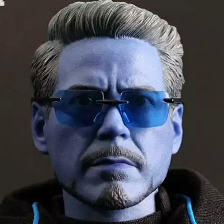

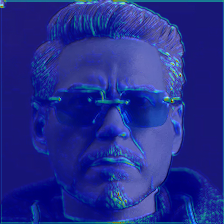

In [0]:
#printlayeroutput("block5_pool")
#printlayeroutput("block5_conv3")
#printlayeroutput("block5_conv2")
#printlayeroutput("block5_conv1")
printlayeroutput("block1_conv2")





In [0]:
#!pip install keras-vis
!pip install pillow
!pip install git+https://github.com/raghakot/keras-vis.git



In [0]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
import matplotlib.pyplot as plt
from vis.visualization import visualize_activation

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'block5_conv1')

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# 20 is the imagenet category for 'ouzel'
#img = visualize_activation(model, layer_idx, filter_indices=20, seed_input=dog)
img = visualize_saliency(model, layer_idx, filter_indices=20, seed_input=dog, backprop_modifier='guided')
plt.imshow(img, cmap='jet')

